In [1]:
import pyrootutils
from pathlib import Path

# Point to your repo root manually
root = pyrootutils.setup_root(
    Path().resolve().parent,  # current working dir
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=False,
)

In [2]:
import numpy as np
import torch
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from skimage import filters, morphology, exposure, measure, morphology, segmentation

from src.data_modules.hsi_dermoscopy import HSIDermoscopyDataModule
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyTask

/mnt/data/kristhian/miniforge3/envs/hyper/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_module = HSIDermoscopyDataModule(data_dir="../data/hsi_dermoscopy",
    task=HSIDermoscopyTask.CLASSIFICATION_ALL_CLASSES,
                                      train_val_test_split=[.70, .15, .15],
                                      batch_size=8,
                                      transforms=None)
data_module.prepare_data()
data_module.setup()
data_loader = data_module.all_dataloader()
dataset = data_loader.dataset

# iterate over the dataset and get the max and min values of the hyperspectral images
max_value = -np.inf
min_value = np.inf
for i in tqdm.tqdm(range(len(dataset))):
    image, label = dataset[i]
    max_value = max(max_value, image.max())
    min_value = min(min_value, image.min())
print(f"Max value: {max_value}, Min value: {min_value}")

  0%|          | 0/333 [00:00<?, ?it/s]

100%|██████████| 333/333 [00:18<00:00, 17.93it/s]

Max value: 2.0600955486297607, Min value: -0.19400253891944885


In [4]:
data_module = HSIDermoscopyDataModule(data_dir="../data/hsi_dermoscopy",
    task=HSIDermoscopyTask.SEGMENTATION,
                                      train_val_test_split=[.70, .15, .15],
                                      batch_size=16,
                                      transforms=None)
data_module.prepare_data()
data_module.setup()
data_loader = data_module.all_dataloader()
dataset = data_loader.dataset

In [5]:
# get first sample
image, mask, label = dataset[0]
print(f"Image shape: {image.shape}, Mask: {mask.shape}, Label: {label}")

Image shape: (272, 512, 16), Mask: torch.Size([272, 512]), Label: 0


In [6]:
def get_non_border_mask(image, iterations=20, threshold=0.1):
    mean_image = image.mean(axis=-1)
    otsu_thresh = filters.threshold_otsu(mean_image)
    binary_mask = mean_image > otsu_thresh
    cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=500)

    contours, _ = cv2.findContours(cleaned_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hull = cv2.convexHull(contours[0])
    hull_mask = np.zeros_like(cleaned_mask.astype(np.uint8))
    cv2.drawContours(hull_mask, [hull], -1, 255, -1)
    cleaned_mask = hull_mask.astype(bool)

    return cleaned_mask

non_border_mask = get_non_border_mask(image)

In [7]:
# Reverse map integer label -> string name
inverse_labels_map = {v: k for k, v in dataset.dataset.labels_map.items()}

inverse_labels_map[len(inverse_labels_map)] = "normal_skin"  # background class

def compute_spectra_stats(dataset, inverse_labels_map, get_non_border_mask, use_tqdm=True, desc="Calculating spectra"):
    """
    Iterate over a dataset and collect per-label spectra and summary stats.
    Returns (spectra_by_label, stats) where:
      - spectra_by_label: dict[label_name] -> list of spectra (ndarray, bands)
      - stats: dict[label_name] -> {"mean": ndarray, "std": ndarray}
    """
    spectra_by_label = {}
    iterator = range(len(dataset))
    if use_tqdm:
        iterator = tqdm.tqdm(iterator, desc=desc)

    for i in iterator:
        image, mask, label = dataset[i]

        # ensure numpy arrays for mask and label
        mask_np = mask.numpy() if hasattr(mask, "numpy") else np.array(mask)
        label_int = label.item() if hasattr(label, "item") else int(label)
        label_name = inverse_labels_map[label_int]

        # collect spectrum for the object mask (where mask == 1)
        obj_mask = mask_np == 1
        if np.any(obj_mask):
            spectrum = image[obj_mask].mean(axis=0)
            spectra_by_label.setdefault(label_name, []).append(spectrum)

        # collect a "normal_skin" spectrum from non-border areas that are background (mask == 0)
        nb_mask = get_non_border_mask(image)
        normal_skin_mask = nb_mask & (mask_np == 0)
        if np.any(normal_skin_mask):
            normal_spectrum = image[normal_skin_mask].mean(axis=0)
            spectra_by_label.setdefault("normal_skin", []).append(normal_spectrum)

    # Compute mean and std for each label
    stats = {}
    for label_name, spectra in spectra_by_label.items():
        arr = np.array(spectra)
        stats[label_name] = {
            "mean": np.mean(arr, axis=0),
            "std": np.std(arr, axis=0),
        }

    return spectra_by_label, stats

# Run the function to produce the same outputs as before
spectra_by_label, stats = compute_spectra_stats(dataset, inverse_labels_map, get_non_border_mask)

Calculating spectra: 100%|██████████| 312/312 [00:18<00:00, 17.13it/s]


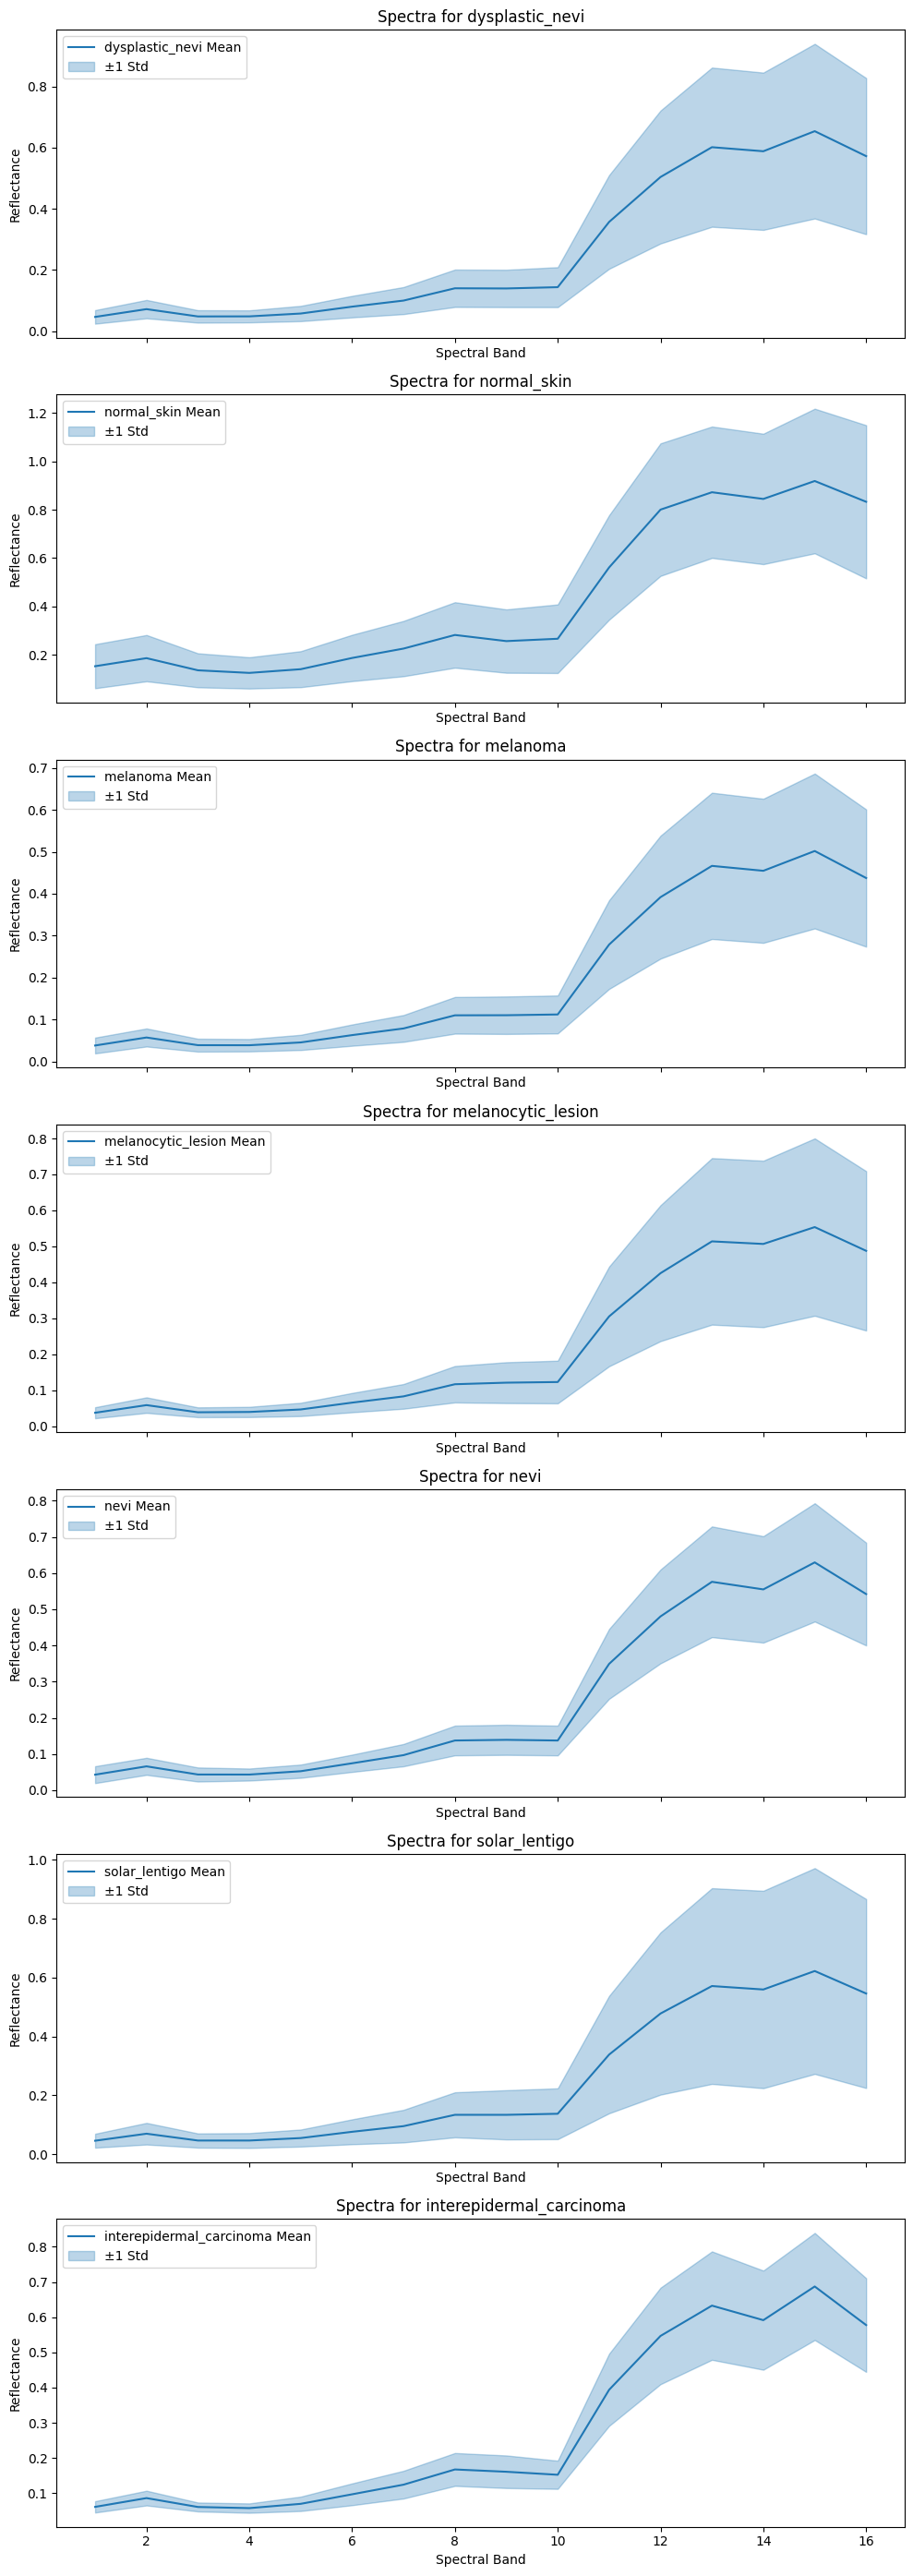

In [8]:
# Plot each label in its own subplot
n_labels = len(stats)
fig, axes = plt.subplots(
    n_labels, 1, figsize=(10, 4 * n_labels), sharex=True
)

if n_labels == 1:  # ensure axes is iterable for one subplot
    axes = [axes]

for ax, (label, values) in zip(axes, stats.items()):
    mean = values["mean"]
    std = values["std"]
    bands = np.arange(1, len(mean) + 1)

    ax.plot(bands, mean, label=f"{label} Mean", color="C0")
    ax.fill_between(
        bands, mean - std, mean + std, alpha=0.3, color="C0", label="±1 Std"
    )
    ax.set_title(f"Spectra for {label}")
    ax.set_xlabel("Spectral Band")
    ax.set_ylabel("Reflectance")
    ax.legend()

plt.tight_layout()
plt.show()

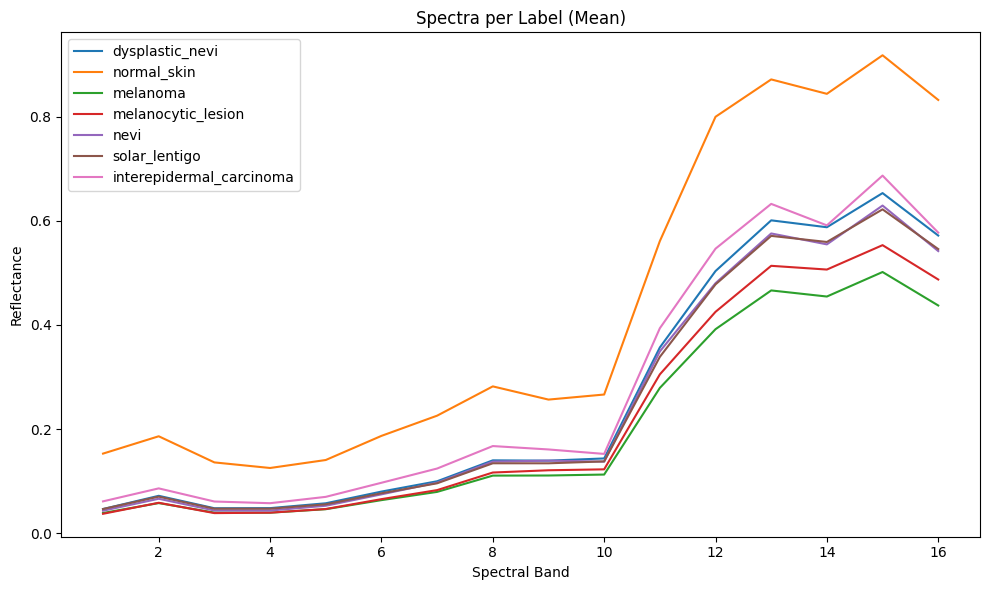

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, (label, values) in enumerate(stats.items()):
    mean = values["mean"]
    bands = np.arange(1, len(mean) + 1)

    color = f"C{i % 10}"  # cycle through Matplotlib's default colors
    ax.plot(bands, mean, label=label, color=color)

ax.set_title("Spectra per Label (Mean)")
ax.set_xlabel("Spectral Band")
ax.set_ylabel("Reflectance")
ax.legend()
plt.tight_layout()
plt.show()


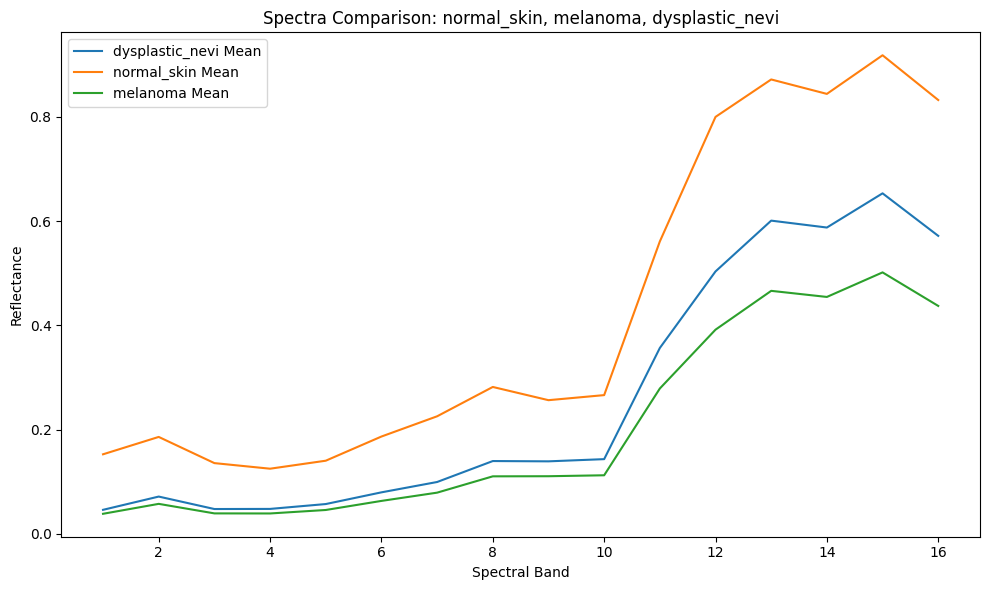

In [10]:
# Define which labels you want to plot
labels_to_plot = ["normal_skin", "melanoma", "dysplastic_nevi"]

# Filter stats to only keep the selected labels
filtered_stats = {
    label: values for label, values in stats.items() if label in labels_to_plot
}

# Toggle standard deviation shading
show_std = False  # <-- set this to False if you don't want the shaded area

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

bands = np.arange(1, len(next(iter(filtered_stats.values()))["mean"]) + 1)

# Plot each label on the same axes
for i, (label, values) in enumerate(filtered_stats.items()):
    mean = values["mean"]
    std = values["std"]

    ax.plot(bands, mean, label=f"{label} Mean", color=f"C{i}")

    if show_std:
        ax.fill_between(
            bands, mean - std, mean + std, alpha=0.2, color=f"C{i}"
        )

ax.set_title("Spectra Comparison: normal_skin, melanoma, dysplastic_nevi")
ax.set_xlabel("Spectral Band")
ax.set_ylabel("Reflectance")
ax.legend()
plt.tight_layout()
plt.show()

/mnt/data/kristhian/miniforge3/envs/hyper/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


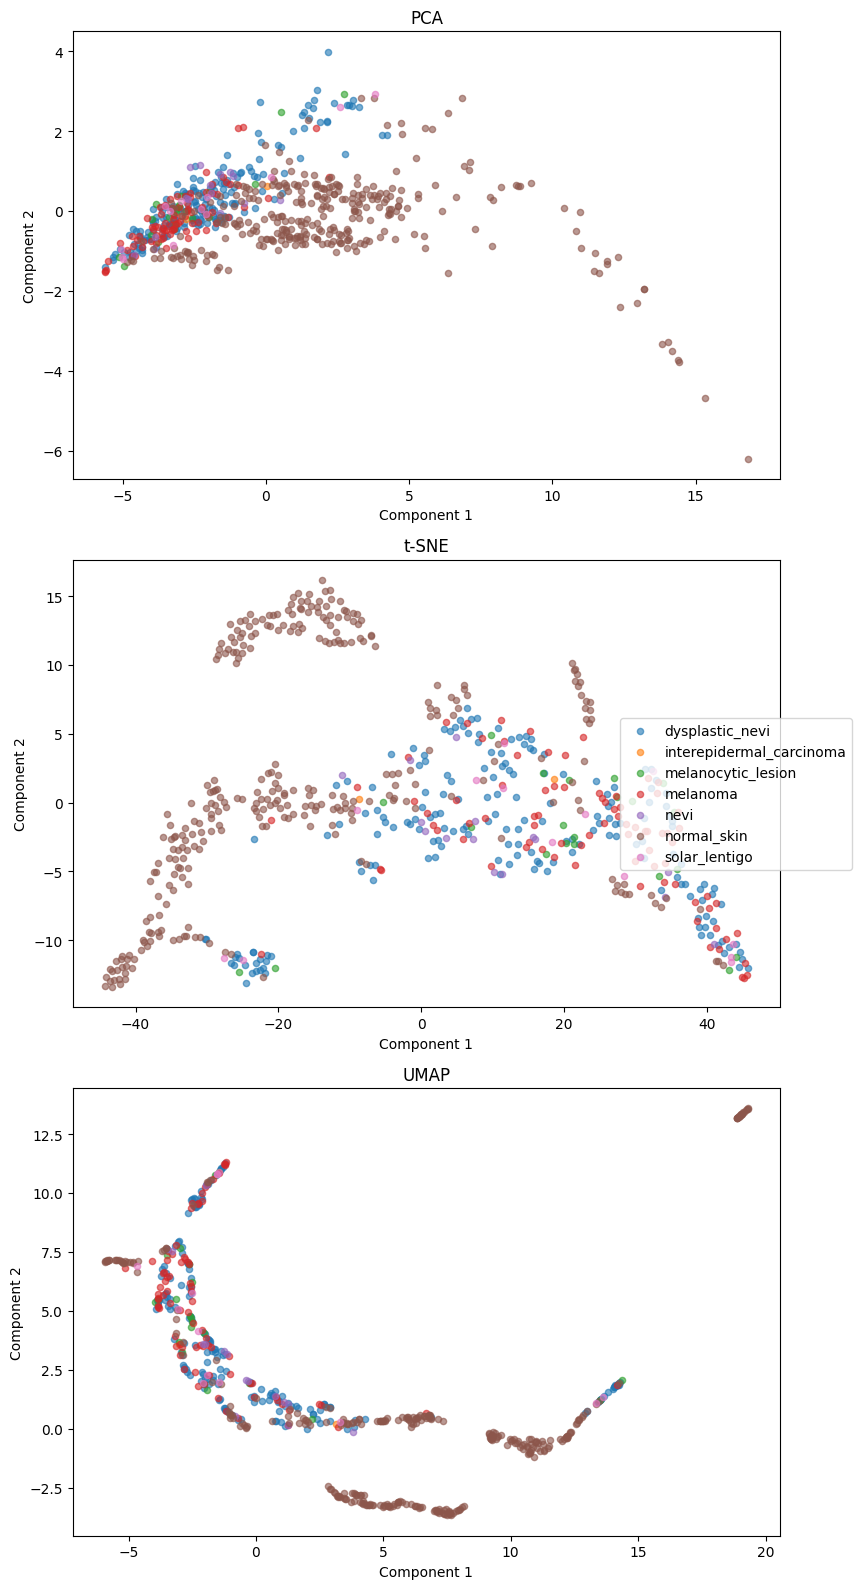

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# --------------------------
# Prepare data (from spectra_by_label)
# --------------------------
X = []  # spectra
y = []  # labels

for label, spectra in spectra_by_label.items():
    for spec in spectra:
        X.append(spec)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Optional: normalize spectra across channels
X = (X - X.mean(axis=0)) / X.std(axis=0)

# --------------------------
# Dimensionality reduction
# --------------------------
X_pca = PCA(n_components=2).fit_transform(X)

X_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=42
).fit_transform(X)

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
).fit_transform(X)

# --------------------------
# Plot helper function
# --------------------------
def plot_scatter(ax, X_2d, labels, title):
    unique_labels = np.unique(labels)
    for label in unique_labels:
        mask = labels == label
        ax.scatter(
            X_2d[mask, 0],
            X_2d[mask, 1],
            label=label,
            alpha=0.6,
            s=20
        )
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

# --------------------------
# Create one figure with subplots
# --------------------------
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

plot_scatter(axes[0], X_pca, y, "PCA")
plot_scatter(axes[1], X_tsne, y, "t-SNE")
plot_scatter(axes[2], X_umap, y, "UMAP")

# Put one legend outside (instead of repeating)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.08, 0.5))

plt.tight_layout()
plt.show()

Calculating spectra: 100%|██████████| 59/59 [00:00<00:00, 77.59it/s]


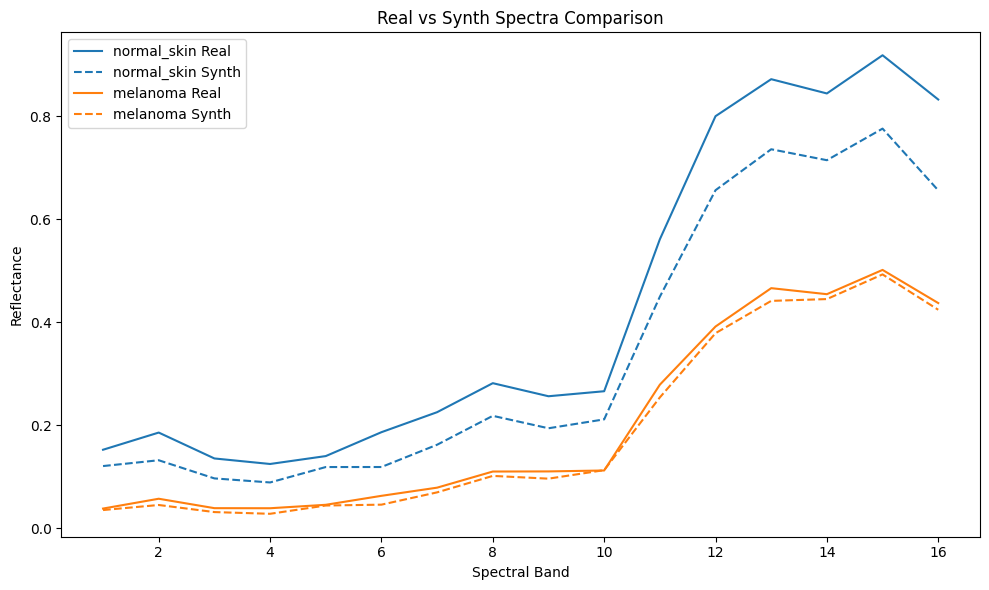

In [12]:
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyDataset

dataset = HSIDermoscopyDataset(task=HSIDermoscopyTask.GENERATION, 
                               data_dir="../data/hsi_dermoscopy_cropped_synth")

use_tqdm = True

spectra_by_label = {}
iterator = range(len(dataset))
if use_tqdm:
    iterator = tqdm.tqdm(iterator, desc="Calculating spectra")

for i in iterator:
    if i in [51, 54, 41, 26, 13, 26, 56, 50, 33, 51]:
        continue

    image, label = dataset[i]

    mean_image = image.mean(axis=-1)
    otsu_thresh = filters.threshold_otsu(mean_image)
    binary_mask = mean_image < (otsu_thresh * 1)
    mask_np = morphology.remove_small_objects(binary_mask, min_size=500)

    # ensure numpy arrays for mask and label
    label_int = label.item() if hasattr(label, "item") else int(label)
    label_name = inverse_labels_map[label_int]

    # collect spectrum for the object mask (where mask == 1)
    if np.any(mask_np):
        spectrum = image[mask_np].mean(axis=0)
        spectra_by_label.setdefault(label_name, []).append(spectrum)

    # collect a "normal_skin" spectrum from non-border areas that are background (mask == 0)
    normal_skin_mask = ~mask_np
    if np.any(normal_skin_mask):
        normal_spectrum = image[normal_skin_mask].mean(axis=0)
        spectra_by_label.setdefault("normal_skin", []).append(normal_spectrum)

# Compute mean and std for each label
synth_stats = {}
for label_name, spectra in spectra_by_label.items():
    arr = np.array(spectra)
    synth_stats[label_name] = {
        "mean": np.mean(arr, axis=0),
        "std": np.std(arr, axis=0),
    }

# Toggle standard deviation shading (set True to show ±1 std)
show_std = False  # change to True to enable shading
# labels_to_plot = ["normal_skin", "melanoma", ]
# plot synth_stats vs real stats for selected labels on the same axes
fig, ax = plt.subplots(figsize=(10, 6))
for i, label in enumerate(labels_to_plot):
    real_values = stats.get(label)
    synth_values = synth_stats.get(label)

    if real_values is None or synth_values is None:
        continue

    real_mean = real_values["mean"]
    real_std = real_values.get("std", None)
    synth_mean = synth_values["mean"]
    synth_std = synth_values.get("std", None)
    bands = np.arange(1, len(real_mean) + 1)

    color = f"C{i}"
    ax.plot(bands, real_mean, label=f"{label} Real", linestyle='-', color=color)
    ax.plot(bands, synth_mean, label=f"{label} Synth", linestyle='--', color=color)

    if show_std:
        if real_std is not None:
            ax.fill_between(bands, real_mean - real_std, real_mean + real_std, alpha=0.2, color=color)
        if synth_std is not None:
            ax.fill_between(bands, synth_mean - synth_std, synth_mean + synth_std, alpha=0.1, color=color)

ax.set_title("Real vs Synth Spectra Comparison")
ax.set_xlabel("Spectral Band")
ax.set_ylabel("Reflectance")
ax.legend()
plt.tight_layout()
plt.show()

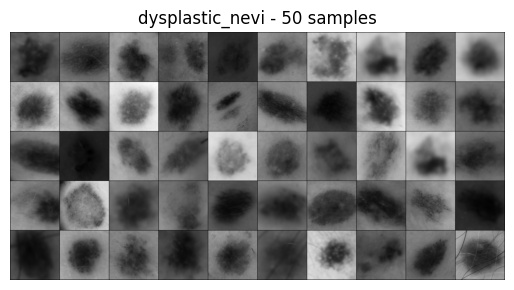

In [13]:
import torchvision
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyDataset
import albumentations as A
dataset = HSIDermoscopyDataset(task=HSIDermoscopyTask.CLASSIFICATION_MELANOMA_VS_DYSPLASTIC_NEVI,
                               transform=A.Compose([
                                   A.SmallestMaxSize(max_size=256),
                                   A.CenterCrop(height=256, width=256),
                               ]),
                               data_dir="../data/hsi_dermoscopy_cropped")
inverse_labels_map = {v: k for k, v in dataset.labels_map.items()}

def show_samples(dataset, max_per_class=50):
    # Dictionary to store samples by class
    samples_by_class = {}

    # Collect samples
    for i in range(len(dataset)):
        image, label = dataset[i]
        label_int = label.item() if hasattr(label, "item") else int(label)
        label_name = inverse_labels_map[label_int]

        if label_name not in samples_by_class:
            samples_by_class[label_name] = []

        if len(samples_by_class[label_name]) < max_per_class:
            # Convert image to RGB by taking mean across spectral bands
            rgb_image = torch.from_numpy(image).float().mean(dim=-1).unsqueeze(0)  # Add channel dimension
            samples_by_class[label_name].append(rgb_image)

        # Check if we have enough samples for all classes
        if all(len(samples) >= max_per_class for samples in samples_by_class.values()):
            break

    # Create figure
    fig = plt.figure(figsize=(15, 3 * len(samples_by_class)))

    # Plot samples for each class
    for i, (label_name, samples) in enumerate(samples_by_class.items()):
        # Make grid of images
        grid = make_grid(torch.stack(samples), nrow=10, normalize=True)

        # Add subplot
        plt.subplot(len(samples_by_class), 1, i + 1)
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"{label_name} - {len(samples)} samples")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Show samples from the dataset
show_samples(dataset)

Calculating spectra: 100%|██████████| 100/100 [00:01<00:00, 69.99it/s]


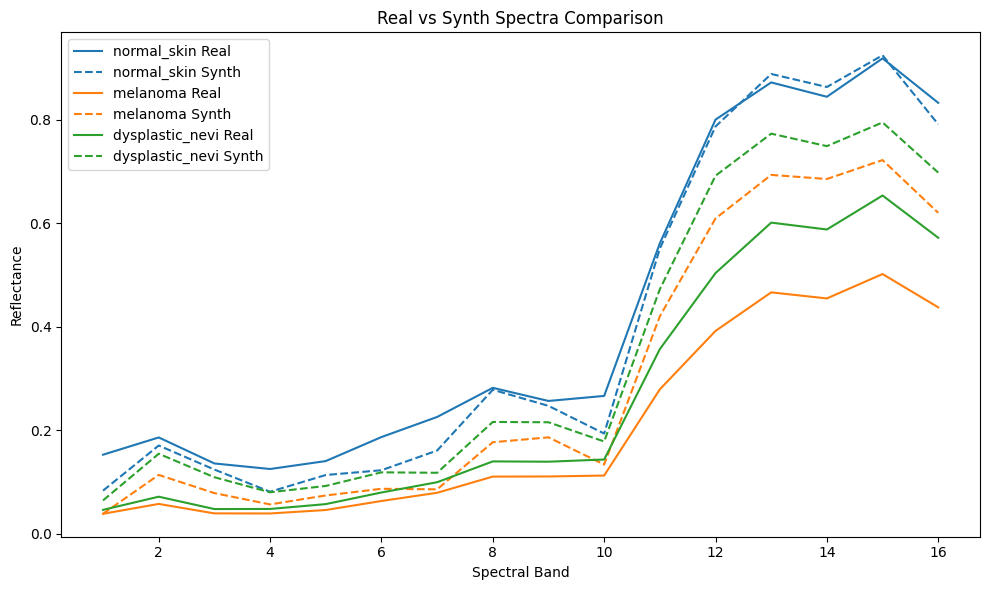

In [14]:
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyDataset

# Reverse map integer label -> string name

dataset = HSIDermoscopyDataset(task=HSIDermoscopyTask.GENERATION,
                               data_dir="../data/synth_melanoma_dysplastic_nevi")
use_tqdm = True
inverse_labels_map = {v: k for k, v in dataset.labels_map.items()}

spectra_by_label = {}
iterator = range(len(dataset))
if use_tqdm:
    iterator = tqdm.tqdm(iterator, desc="Calculating spectra")

for i in iterator:
    image, label = dataset[i]

    mean_image = image.mean(axis=-1)
    otsu_thresh = filters.threshold_otsu(mean_image)
    binary_mask = mean_image < (otsu_thresh * 1)
    mask_np = morphology.remove_small_objects(binary_mask, min_size=500)

    # ensure numpy arrays for mask and label
    label_int = label.item() if hasattr(label, "item") else int(label)
    label_name = inverse_labels_map[label_int]

    # collect spectrum for the object mask (where mask == 1)
    if np.any(mask_np):
        spectrum = image[mask_np].mean(axis=0)
        spectra_by_label.setdefault(label_name, []).append(spectrum)

    # collect a "normal_skin" spectrum from non-border areas that are background (mask == 0)
    normal_skin_mask = ~mask_np
    if np.any(normal_skin_mask):
        normal_spectrum = image[normal_skin_mask].mean(axis=0)
        spectra_by_label.setdefault("normal_skin", []).append(normal_spectrum)

# Compute mean and std for each label
synth_stats = {}
for label_name, spectra in spectra_by_label.items():
    arr = np.array(spectra)
    synth_stats[label_name] = {
        "mean": np.mean(arr, axis=0),
        "std": np.std(arr, axis=0),
    }

# Toggle standard deviation shading (set True to show ±1 std)
show_std = False  # change to True to enable shading
# labels_to_plot = ["normal_skin", "melanoma", ]
# plot synth_stats vs real stats for selected labels on the same axes
fig, ax = plt.subplots(figsize=(10, 6))
for i, label in enumerate(labels_to_plot):
    real_values = stats.get(label)
    synth_values = synth_stats.get(label)

    if real_values is None or synth_values is None:
        continue

    real_mean = real_values["mean"]
    real_std = real_values.get("std", None)
    synth_mean = synth_values["mean"]
    synth_std = synth_values.get("std", None)
    bands = np.arange(1, len(real_mean) + 1)

    color = f"C{i}"
    ax.plot(bands, real_mean, label=f"{label} Real", linestyle='-', color=color)
    ax.plot(bands, synth_mean, label=f"{label} Synth", linestyle='--', color=color)

    if show_std:
        if real_std is not None:
            ax.fill_between(bands, real_mean - real_std, real_mean + real_std, alpha=0.2, color=color)
        if synth_std is not None:
            ax.fill_between(bands, synth_mean - synth_std, synth_mean + synth_std, alpha=0.1, color=color)

ax.set_title("Real vs Synth Spectra Comparison")
ax.set_xlabel("Spectral Band")
ax.set_ylabel("Reflectance")
ax.legend()
plt.tight_layout()
plt.show()

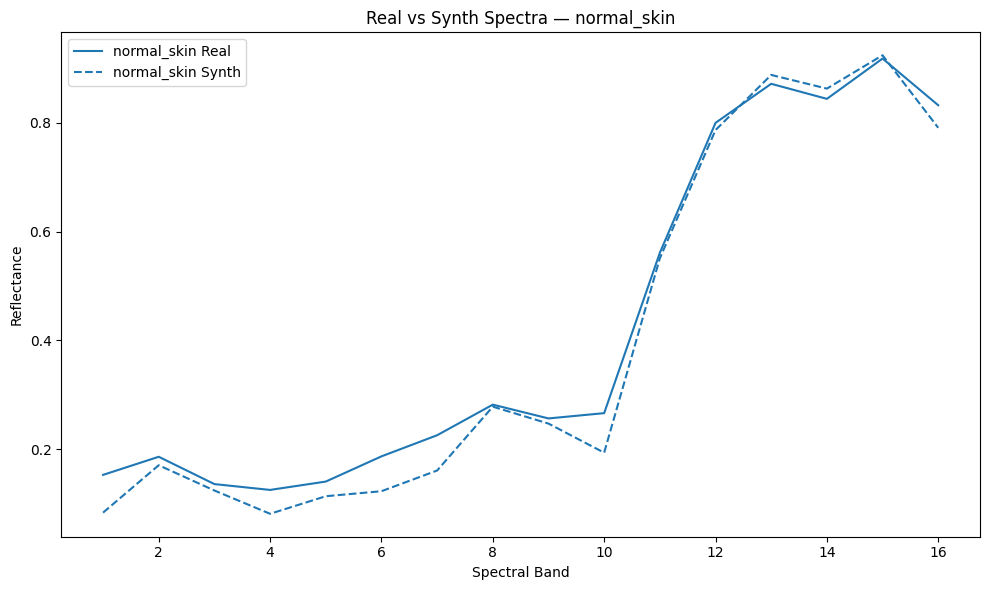

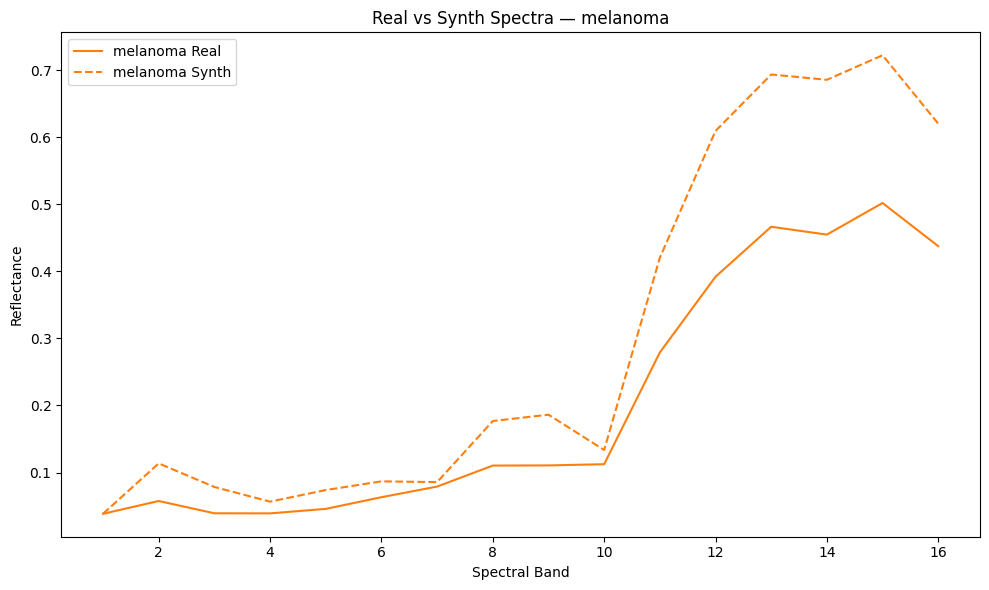

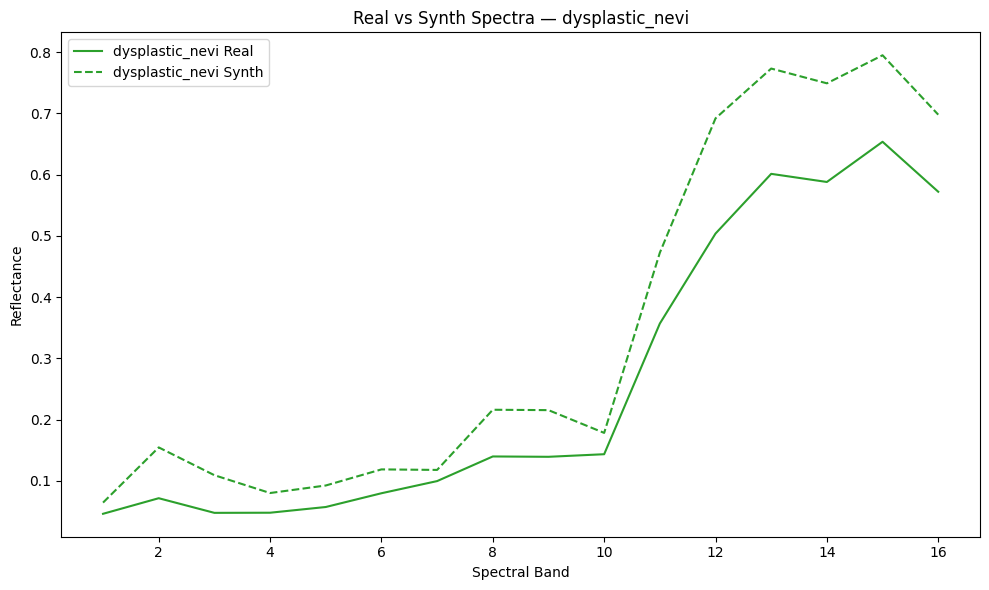

In [15]:
# List of labels to generate individual plots for
labels_to_plot = ["normal_skin", "melanoma", "dysplastic_nevi"]

show_std = False  # flip to True if you want shaded ±1 std regions

for i, label in enumerate(labels_to_plot):
    real_values = stats.get(label)
    synth_values = synth_stats.get(label)

    if real_values is None or synth_values is None:
        print(f"Skipping '{label}' — missing data.")
        continue

    real_mean = real_values["mean"]
    real_std = real_values.get("std", None)
    synth_mean = synth_values["mean"]
    synth_std = synth_values.get("std", None)
    bands = np.arange(1, len(real_mean) + 1)

    color = f"C{i}"

    # Create a new figure for each label
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(bands, real_mean, label=f"{label} Real", linestyle="-", color=color)
    ax.plot(bands, synth_mean, label=f"{label} Synth", linestyle="--", color=color)

    if show_std:
        if real_std is not None:
            ax.fill_between(
                bands,
                real_mean - real_std,
                real_mean + real_std,
                alpha=0.2,
                color=color,
            )
        if synth_std is not None:
            ax.fill_between(
                bands,
                synth_mean - synth_std,
                synth_mean + synth_std,
                alpha=0.1,
                color=color,
            )

    ax.set_title(f"Real vs Synth Spectra — {label}")
    ax.set_xlabel("Spectral Band")
    ax.set_ylabel("Reflectance")
    ax.legend()
    plt.tight_layout()
    plt.show()

Calculating spectra (../data/hsi_dermoscopy_cropped_synth_beta_vae): 100%|██████████| 64/64 [00:00<00:00, 151.95it/s]
Calculating spectra (../data/hsi_dermoscopy_cropped_synth): 100%|██████████| 59/59 [00:00<00:00, 159.88it/s]
Calculating spectra (../data/hsi_dermoscopy_cropped_synth_fsgan): 100%|██████████| 59/59 [00:00<00:00, 159.30it/s]


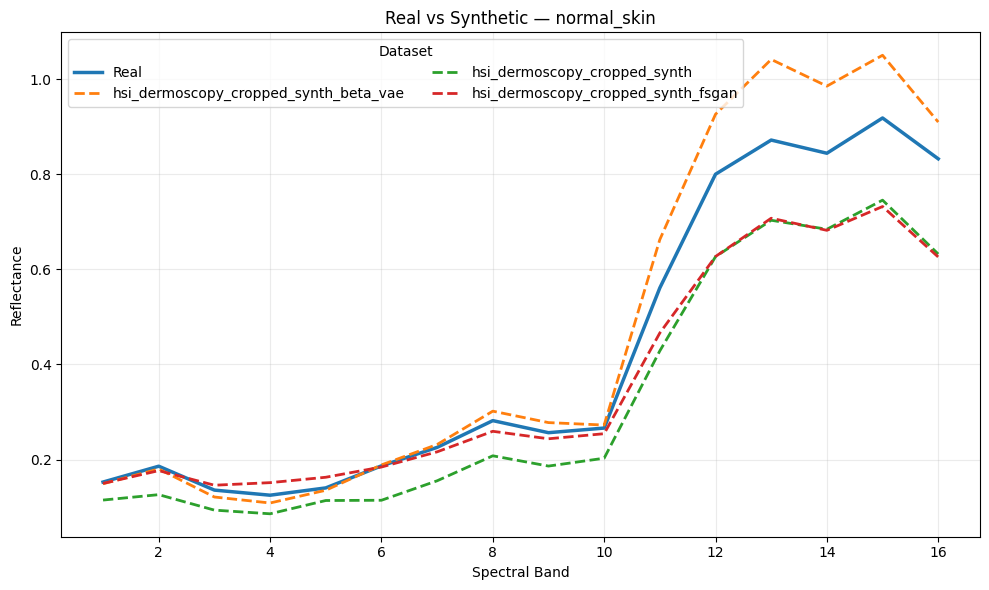

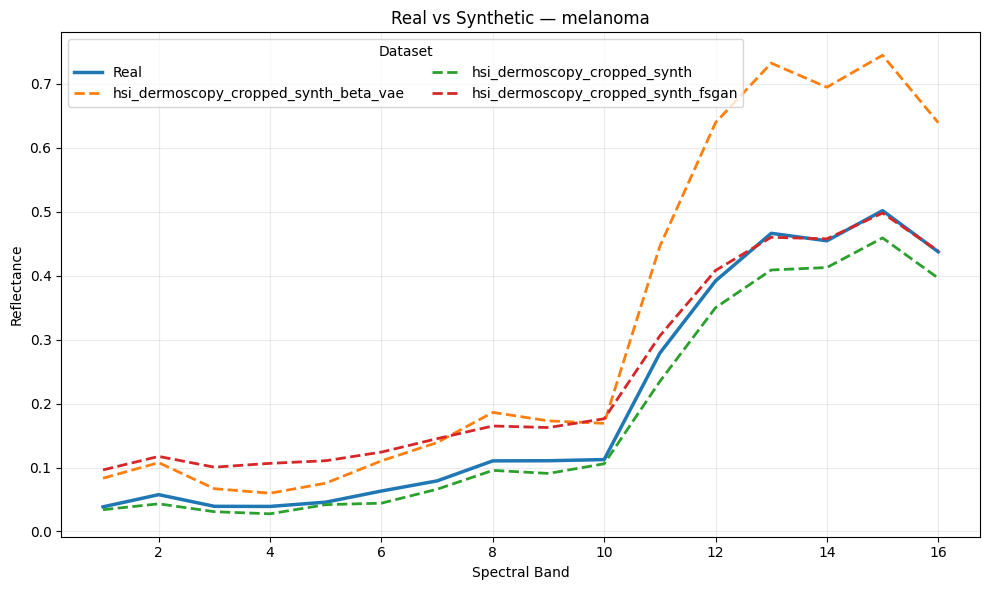

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Define which labels to compare
labels_to_compare = ["normal_skin", "melanoma"]

# 2) Colors fixed per class
class_colors = {
    "normal_skin": "C0",
    "melanoma": "C3",
}

# 3) Line styles for different synthetic generations
synth_styles = [
    "--",   # style 0
    "-.",   # style 1
    ":",    # style 2
    (0, (3, 1, 1, 1)),  # style 3 (custom dash pattern)
]

# 4) Optional display of ±1 std bands
show_std = False

# 5) Helper to make legend names cleaner
def display_name(key: str) -> str:
    # If you use paths as keys, show the tail; otherwise return as-is
    # e.g., "../data/hsi_dermoscopy_cropped_synth_beta_vae" -> "hsi_dermoscopy_cropped_synth_beta_vae"
    parts = key.replace("\\", "/").rstrip("/").split("/")
    return parts[-1] if parts else key

# 6) Plotting function
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_each_class_sep_consistent_style(
    labels,
    real_stats,
    synth_stats_map,
    show_std=False,
):
    # 1) Check reference for band axis length
    ref_label = next((lbl for lbl in labels if real_stats.get(lbl) is not None), None)
    if ref_label is None:
        raise ValueError("No real stats available to determine band axis.")
    n_bands = len(real_stats[ref_label]["mean"])
    bands = np.arange(1, n_bands + 1)

    # 2) Assign one color per dataset (real + synthetic sources)
    # Always use the same mapping across all label plots
    dataset_names = ["Real"] + [display_name(k) for k in synth_stats_map.keys()]
    color_cycle = plt.cm.tab10.colors  # a set of distinct colors
    dataset_colors = {
        name: color_cycle[i % len(color_cycle)] for i, name in enumerate(dataset_names)
    }

    # 3) Define line styles
    real_style = "-"
    synth_style = "--"

    # 4) One plot per label
    for lbl in labels:
        rs = real_stats.get(lbl)
        if rs is None:
            print(f"Skipping '{lbl}' — missing real stats.")
            continue

        fig, ax = plt.subplots(figsize=(10, 6))

        # ----- Plot Real Dataset -----
        r_mean = rs["mean"]
        r_std = rs.get("std", None)
        ax.plot(
            bands,
            r_mean,
            linestyle=real_style,
            linewidth=2.5,
            color=dataset_colors["Real"],
            label="Real",
        )
        if show_std and r_std is not None:
            ax.fill_between(
                bands,
                r_mean - r_std,
                r_mean + r_std,
                color=dataset_colors["Real"],
                alpha=0.15,
            )

        # ----- Plot Synthetic Datasets -----
        for key, synth_stats in synth_stats_map.items():
            name = display_name(key)
            ss = synth_stats.get(lbl)
            if ss is None:
                print(f"Skipping {name} for '{lbl}' — missing data.")
                continue
            s_mean = ss["mean"]
            s_std = ss.get("std", None)

            ax.plot(
                bands,
                s_mean,
                linestyle=synth_style,
                linewidth=2.0,
                color=dataset_colors[name],
                label=name,
            )
            if show_std and s_std is not None:
                ax.fill_between(
                    bands,
                    s_mean - s_std,
                    s_mean + s_std,
                    color=dataset_colors[name],
                    alpha=0.07,
                )

        # ----- Final Touches -----
        ax.set_title(f"Real vs Synthetic — {lbl}")
        ax.set_xlabel("Spectral Band")
        ax.set_ylabel("Reflectance")
        ax.legend(title="Dataset", ncol=2)
        ax.grid(True, alpha=0.25)
        plt.tight_layout()
        plt.show()

# Pseudocode for computing synth_stats per dataset_dir using your current approach
def compute_synth_stats_for_dir(data_dir, use_tqdm=True):
    dataset = HSIDermoscopyDataset(
        task=HSIDermoscopyTask.GENERATION, data_dir=data_dir
    )
    inverse_labels_map = {v: k for k, v in dataset.labels_map.items()}
    spectra_by_label = {}

    iterator = range(len(dataset))
    if use_tqdm:
        iterator = tqdm.tqdm(iterator, desc=f"Calculating spectra ({data_dir})")

    for i in iterator:
        image, label = dataset[i]
        mean_image = image.mean(axis=-1)
        otsu_thresh = filters.threshold_otsu(mean_image)
        binary_mask = mean_image < (otsu_thresh * 1)
        mask_np = morphology.remove_small_objects(binary_mask, min_size=500)

        label_int = label.item() if hasattr(label, "item") else int(label)
        label_name = inverse_labels_map[label_int]

        if np.any(mask_np):
            spectrum = image[mask_np].mean(axis=0)
            spectra_by_label.setdefault(label_name, []).append(spectrum)

        normal_skin_mask = ~mask_np
        if np.any(normal_skin_mask):
            normal_spectrum = image[normal_skin_mask].mean(axis=0)
            spectra_by_label.setdefault("normal_skin", []).append(normal_spectrum)

    synth_stats = {}
    for label_name, spectra in spectra_by_label.items():
        arr = np.array(spectra)
        synth_stats[label_name] = {
            "mean": np.mean(arr, axis=0),
            "std": np.std(arr, axis=0),
        }
    return synth_stats

# Define which synthetic dirs to compare
synth_dirs = [
    "../data/hsi_dermoscopy_cropped_synth_beta_vae",
    "../data/hsi_dermoscopy_cropped_synth",
    "../data/hsi_dermoscopy_cropped_synth_fsgan",
]

# Build the map
synth_stats_map = {d: compute_synth_stats_for_dir(d, use_tqdm=True) for d in synth_dirs}

# Finally, plot
plot_each_class_sep_consistent_style(
    labels=labels_to_compare,
    real_stats=stats,
    synth_stats_map=synth_stats_map,
    show_std=show_std,
)